In [1]:
##################################################
# @author Thyrix (Jia-Qi) Yang
# @email thyrixyang@gmail.com
# @create date 2021-12-06 16:17:02
# 
# RID-Noise: Towards Robust Inverse Design under Noisy Environments, AAAI'22
##################################################


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    rad = np.arctan2(y, x)
    rad[rad < 0] += np.pi * 2
    return(rho, rad)


def pol2cart(rho, rad):
    x = rho * np.cos(rad)
    y = rho * np.sin(rad)
    return(x, y)


def random_ball(num, radi):
    x = np.random.randn(num, 2)
    x /= np.reshape(np.sqrt(x[:, 0]**2 + x[:, 1]**2), (-1, 1))
    r = np.random.uniform(0, radi, size=(num, 1))**(1/2)
    x *= r
    return x


class NoisyEnv:

    def __init__(self, x_noise_std, y_noise_std):
        self.x_noise_std = x_noise_std
        self.y_noise_std = y_noise_std

    def noisy_forward(self, x):
        noisy_x = x + np.random.randn(*x.shape) * self.x_noise_std
        _y = self.forward(noisy_x)
        noisy_y = _y + np.random.randn(*_y.shape) * self.y_noise_std
        return noisy_y


class CartesianRadian(NoisyEnv):

    def __init__(self,
                 x_noise_std,
                 y_noise_std):
        super().__init__(x_noise_std, y_noise_std)

    def forward(self, x):
        _, rad = cart2pol(x[:, 0], x[:, 1])
        return np.reshape(rad, (-1, 1))

    def generate_random_x(self, num):
        x = np.random.randn(num, 2)
        return x


class ThreeClustersX(NoisyEnv):

    def __init__(self,
                 cluster_num,
                 div,
                 x_noise_std,
                 y_noise_std):
        super().__init__(x_noise_std, y_noise_std)
        self.cluster_num = cluster_num
        self.div = div

    def forward(self, x):
        _, label_rad = cart2pol(x[:, 0], x[:, 1])
        label_rad *= self.cluster_num / (2 * np.pi)
        label_rad += 0.5
        label = np.floor(label_rad)
        label[label > self.cluster_num - 0.5] = 0
        y = np.reshape(label / self.cluster_num, (-1, 1))
        return y

    def generate_random_x(self, num):
        cluster_id = np.random.randint(
            low=0, high=self.cluster_num, size=(num, 1)).astype(np.float32)/self.cluster_num
        rad = cluster_id * np.pi * 2
        x1, x2 = pol2cart(1, rad)
        x = np.concatenate([x1, x2], axis=1)
        x += np.random.randn(*x.shape) * self.div
        return x


class TwoClustersRhoY(NoisyEnv):

    def __init__(self,
                 noise,
                 radi):
        self.noise = noise
        self.radi = radi

    def forward(self, x):
        s0 = x[:, 0] > 0
        s1 = x[:, 0] <= 0
        y = np.zeros((x.shape[0], 1))
        rho0, _ = cart2pol(x[s0, 0] - 1, x[s0, 1])
        rho1, _ = cart2pol(x[s1, 0] + 1, x[s1, 1])
        y[s0] = np.reshape(rho0, (-1, 1))
        y[s1] = np.reshape(rho1, (-1, 1))
        return y

    def noisy_forward(self, x):
        y = self.forward(x)
        s0 = x[:, 0] > 0
        s1 = x[:, 0] <= 0
        noise = np.random.randn(*y.shape)
        y[s0] += noise[s0] * self.noise[0]
        y[s1] += noise[s1] * self.noise[1]
        y = np.clip(y, a_min=0, a_max=self.radi)
        return y

    def generate_random_x(self, num):
        cluster_id = np.random.randint(
            low=0, high=2, size=(num,))
        x = np.zeros((num, 2))
        s0 = cluster_id == 0
        s1 = cluster_id == 1
        s0n = np.sum(s0)
        s1n = np.sum(s1)
        x[s0] = random_ball(s0n, radi=self.radi)
        x[s1] = random_ball(s1n, radi=self.radi)
        x[s0, 0] += 1
        x[s1, 0] -= 1
        return x

In [2]:
import pickle
from copy import deepcopy
import os
import random
import itertools

from sklearn.utils import shuffle
import torch
import torch.nn as nn
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet, ConditionNode
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom

def plot_scatter(x, y, c, title="", v_value=[None, None]):
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    scat = plt.scatter(x,
                       y,
                       c=c,
                       alpha=plt_alpha,
                       s=plt_point_size,
                       vmin=v_value[0],
                       vmax=v_value[1])
    plt.colorbar(scat)
    plt.show()


class MLP(nn.Module):

    def __init__(self, input_size, output_size, hidden_sizes, bn, dropout=0.5):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.bn = bn
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.layers.append(
                    nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())
            if bn:
                self.layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            self.layers.append(nn.Dropout(dropout))
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x, _=None):
        for layer in self.layers[:-1]:
            x = layer(x)
        out = self.layers[-1](x)
        return out


def get_Conditional_INN_model(input_dim, condition_dim, hidden_size, layer_num):
    def subnet_fc(in_dim, out_dim):
        return nn.Sequential(nn.Linear(in_dim, hidden_size), nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size), nn.ReLU(),
                             nn.Linear(hidden_size,  out_dim))
    cond_node = ConditionNode(condition_dim)
    nodes = [InputNode(input_dim, name='input')]
    for i in range(layer_num):
        nodes.append(Node(nodes[-1], GLOWCouplingBlock,
                          {'subnet_constructor': subnet_fc,
                           'clamp': 2.0},
                          conditions=cond_node,
                          name='coupling_{}'.format(i)))
        nodes.append(Node(nodes[-1], PermuteRandom,
                          {'seed': i}, name='permute_{}'.format(i)))
    nodes.append(OutputNode(nodes[-1], name='output'))
    nodes.append(cond_node)
    return ReversibleGraphNet(nodes, verbose=False)


def train_and_plot_conditional_inn(tau,
                                   train_x,
                                   train_y,
                                   vali_x,
                                   vali_y,
                                   test_x,
                                   test_y,
                                   vali_loss):
    weights = vali_loss
    weights /= np.mean(weights)
    weights = np.exp(-tau * weights)
    weights /= np.mean(weights)
    plot_scatter(train_x[:, 0], train_x[:, 1], weights,
                 title="weights, tau={}".format(tau), v_value=[0, 1])
    weights = torch.tensor(weights, dtype=torch.float32,
                           device=device).view((-1, 1))
    model = get_Conditional_INN_model(x_dim,
                                      y_dim,
                                      hidden_size=hidden_size,
                                      layer_num=layer_num)
    model = model.to(device)
    best_sd = model.state_dict()
    best_loss = 1e9

    def plot(x, y):
        plot_x = []
        plot_y = []
        model.eval()
        x = torch.tensor(x).to(device)
        y = torch.tensor(y).to(device)
        random_z = torch.randn_like(x)
        backward_output, _ = model(random_z, c=y, rev=True)
        y_np = y.detach().cpu().numpy()
        x_np = backward_output.detach().cpu().numpy()
        plot_x.append(x_np)
        plot_y.append(y_np)
        plot_x = np.concatenate(plot_x, axis=0)
        label = env.noisy_forward(plot_x)
        plot_y = np.concatenate(plot_y, axis=0)
        mse = np.mean((label - plot_y)**2)
        acc = np.mean(np.isclose(label, plot_y))
        title_string = "acc: {:1.5f}, mse: {:2.8f}".format(acc, mse)
        plot_scatter(plot_x[:, 0], plot_x[:, 1], plot_y,
                     title_string)

    model.train()
    trainable_parameters = [
        p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    lr_schedular = ReduceLROnPlateau(
        optimizer, factor=0.5, patience=200, threshold=1e-4, verbose=False)
    tensor_x = torch.tensor(train_x, device=device)
    tensor_y = torch.tensor(train_y, device=device)
    tensor_vali_x = torch.tensor(vali_x, device=device)
    tensor_vali_y = torch.tensor(vali_y, device=device)
    for ep in range(1, epoch + 1):
        model.train()
        x = tensor_x.to(device)
        y = tensor_y.to(device)

        forward_output, forward_log_jac_det = model(x, c=y)
        forward_log_jac_det = forward_log_jac_det.view((-1, 1))
        ll_loss = torch.sum(forward_output**2, dim=1, keepdim=True) * 0.5 \
            - forward_log_jac_det
        wll_loss = weights * ll_loss
        loss = torch.mean(wll_loss)
        optimizer.zero_grad()
        loss.backward()
        for p in trainable_parameters:
            p.grad.data.clamp_(-10.00, 10.00)
        optimizer.step()
        lr_schedular.step(loss.item())

        # validation
        model.eval()
        forward_output, forward_log_jac_det = model(
            tensor_vali_x, c=tensor_vali_y)
        forward_log_jac_det = forward_log_jac_det.view((-1, 1))
        ll_loss = torch.sum(forward_output**2, dim=1, keepdim=True) * 0.5 \
            - forward_log_jac_det
        vali_wll_loss = weights * ll_loss
        vali_loss = torch.mean(vali_wll_loss)

        if vali_loss.item() < best_loss:
            best_loss = vali_loss.item()
            best_sd = model.state_dict()
        if ep % 300 == 0:
            plot(test_x, test_y)
            print("epoch {}, loss {}, z_ll_loss {}, weights {}, wll {}".format(
                ep, loss.item(),
                torch.mean(ll_loss).item(), torch.mean(weights).item(), torch.mean(wll_loss).item()))
    model.load_state_dict(best_sd)
    plot(test_x, test_y)


def train_weights(train_x, train_y):
    split_num = 10
    epoch = 2000
    train_xs = np.split(train_x, split_num, axis=0)
    train_ys = np.split(train_y, split_num, axis=0)
    index = np.split(
        np.array(list(range(train_x.shape[0]))), split_num, axis=0)
    weights = np.zeros((train_x.shape[0],))
    for sn in range(split_num):
        critic = MLP(x_dim, y_dim, hidden_sizes=[
            256, 256, 256], bn=True, dropout=0.5)
        critic = critic.to(device)
        critic.train()
        optimizer = torch.optim.Adam(critic.parameters(),
                                     lr=1e-3,
                                     weight_decay=1e-4)
        schedular = ReduceLROnPlateau(optimizer=optimizer,
                                      factor=0.5,
                                      patience=50,
                                      verbose=False)
        _train_x = []
        _train_y = []
        _train_idx = []
        for i, (xs, ys, idx) in enumerate(zip(train_xs, train_ys, index)):
            if i == sn:
                _vali_x = xs
                _vali_y = ys
            else:
                _train_x.append(xs)
                _train_y.append(ys)
                _train_idx.append(idx)
        _train_x = np.concatenate(_train_x, axis=0)
        _train_y = np.concatenate(_train_y, axis=0)
        _train_idx = np.concatenate(_train_idx, axis=0)
        _vali_x = torch.tensor(_vali_x, dtype=torch.float32, device=device)
        _vali_y = torch.tensor(_vali_y, dtype=torch.float32, device=device)
        _train_x = torch.tensor(_train_x, dtype=torch.float32, device=device)
        _train_y = torch.tensor(_train_y, dtype=torch.float32, device=device)
        best_vali_loss = 1e9
        best_sd = None
        for ep in range(epoch):
            critic.train()
            _pred_y = critic(_train_x)
            loss = torch.mean((_pred_y - _train_y)**2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            schedular.step(loss.item())

            critic.eval()
            _pred_y = critic(_vali_x)
            vali_loss = torch.mean((_pred_y - _vali_y)**2)
            if vali_loss.item() < best_vali_loss:
                best_sd = critic.state_dict()
                best_vali_loss = vali_loss.item()
            if (ep+1) % 500 == 0:
                print("sn {}, ep {}, train_loss {}, best_vali_loss {}".format(
                    sn, ep, loss.item(), best_vali_loss))
        critic.load_state_dict(best_sd)
        critic.eval()
        _pred_y = critic(_train_x)
        loss = torch.mean((_pred_y - _train_y)**2, axis=-
                          1).detach().cpu().numpy()
        weights[_train_idx] += loss
    weights *= (split_num - 1) / split_num
    return weights

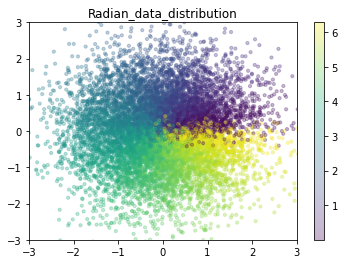

sn 0, ep 499, train_loss 1.165004014968872, best_vali_loss 0.926575243473053
sn 0, ep 999, train_loss 0.9587961435317993, best_vali_loss 0.926575243473053
sn 0, ep 1499, train_loss 0.912916362285614, best_vali_loss 0.926575243473053
sn 0, ep 1999, train_loss 0.921504557132721, best_vali_loss 0.926575243473053
sn 1, ep 499, train_loss 1.1847586631774902, best_vali_loss 0.6487300395965576
sn 1, ep 999, train_loss 0.9873009920120239, best_vali_loss 0.6314373016357422
sn 1, ep 1499, train_loss 0.9700967073440552, best_vali_loss 0.6312554478645325
sn 1, ep 1999, train_loss 0.9820059537887573, best_vali_loss 0.6312554478645325
sn 2, ep 499, train_loss 1.157561182975769, best_vali_loss 0.9292231798171997
sn 2, ep 999, train_loss 0.9480103254318237, best_vali_loss 0.9081398248672485
sn 2, ep 1499, train_loss 0.9576074481010437, best_vali_loss 0.9081398248672485
sn 2, ep 1999, train_loss 0.9583749175071716, best_vali_loss 0.9081398248672485
sn 3, ep 499, train_loss 1.1699472665786743, best_vali

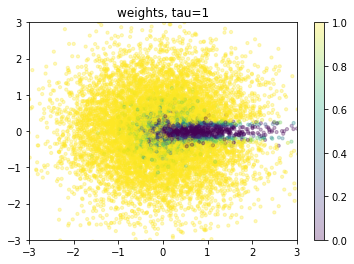

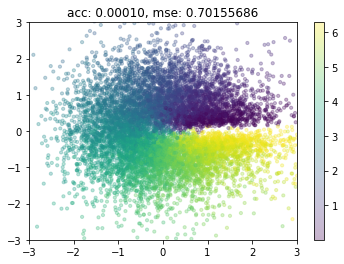

epoch 300, loss -1.1063241958618164, z_ll_loss -0.6120732426643372, weights 1.0, wll -1.1063241958618164


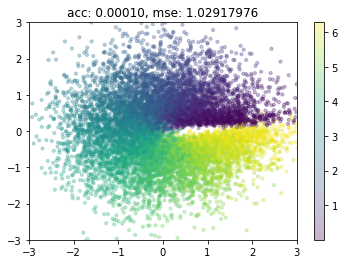

epoch 600, loss -1.1388617753982544, z_ll_loss -0.5059261918067932, weights 1.0, wll -1.1388617753982544


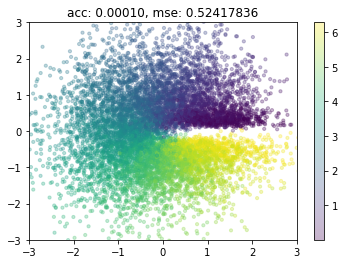

epoch 900, loss -1.0206092596054077, z_ll_loss -0.24737338721752167, weights 1.0, wll -1.0206092596054077


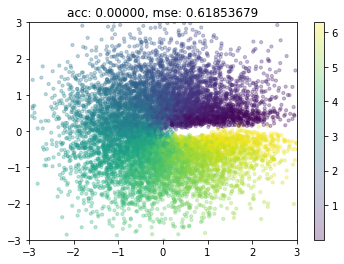

epoch 1200, loss -1.1410741806030273, z_ll_loss -0.44139280915260315, weights 1.0, wll -1.1410741806030273


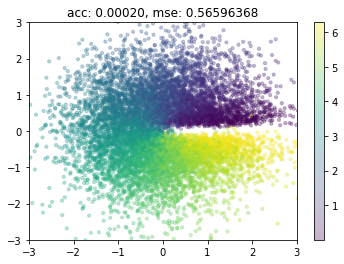

epoch 1500, loss -1.173539161682129, z_ll_loss 0.13405513763427734, weights 1.0, wll -1.173539161682129


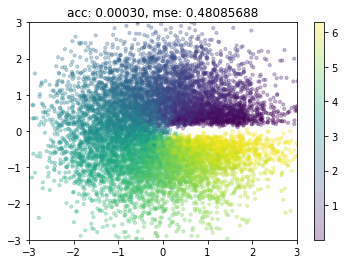

epoch 1800, loss -1.2015269994735718, z_ll_loss 2.6965560913085938, weights 1.0, wll -1.2015269994735718


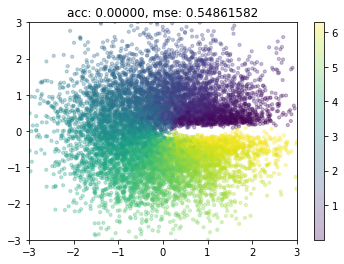

epoch 2100, loss -1.2269773483276367, z_ll_loss 11.171063423156738, weights 1.0, wll -1.2269773483276367


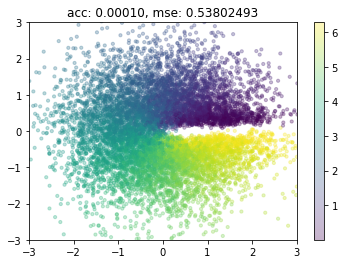

epoch 2400, loss -1.2302565574645996, z_ll_loss 124.15594482421875, weights 1.0, wll -1.2302565574645996


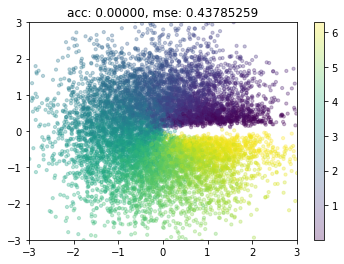

epoch 2700, loss -1.2152036428451538, z_ll_loss 400.498779296875, weights 1.0, wll -1.2152036428451538


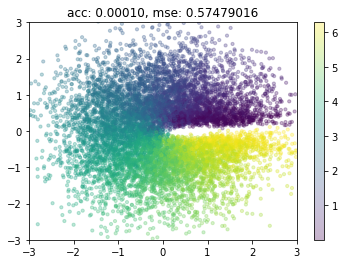

epoch 3000, loss -1.2119719982147217, z_ll_loss 323.598388671875, weights 1.0, wll -1.2119719982147217


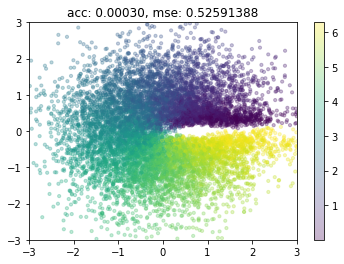

In [3]:
# hyper-parameters
# ----------- train -------------
device = "cuda"
epoch = 3000
lr = 1e-3

# ----------- data --------------
data_num = 10000
x_dim = 2
y_dim = 1

# ----------- model -------------
hidden_size = 256
layer_num = 8

# ----------- plot -------------
plt_point_size = 10
plt_alpha = 0.3
xlim = (-3, 3)
ylim = (-3, 3)

# reproduciability
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# generate data
data_type = "cart"

if data_type == "cart":
    env = CartesianRadian(x_noise_std=0.2, y_noise_std=0)
else:
    raise NotImplementedError()

train_x = env.generate_random_x(num=data_num).astype(np.float32)
train_y = env.noisy_forward(train_x).astype(np.float32)
vali_x = env.generate_random_x(num=data_num).astype(np.float32)
vali_y = env.noisy_forward(vali_x).astype(np.float32)
test_x = env.generate_random_x(num=data_num).astype(np.float32)
test_y = env.noisy_forward(test_x).astype(np.float32)

plot_scatter(train_x[:, 0],
             train_x[:, 1],
             train_y,
             "Radian_data_distribution")
vali_loss = train_weights(train_x, train_y)
tau = 1
train_and_plot_conditional_inn(
    tau, train_x, train_y, vali_x, vali_y, test_x, test_y, vali_loss)

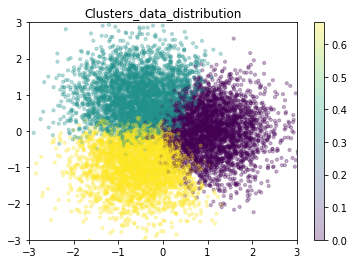

sn 0, ep 499, train_loss 0.015520178712904453, best_vali_loss 0.012431208975613117
sn 0, ep 999, train_loss 0.013000202365219593, best_vali_loss 0.012254063040018082
sn 0, ep 1499, train_loss 0.01276643481105566, best_vali_loss 0.012254063040018082
sn 0, ep 1999, train_loss 0.012765277177095413, best_vali_loss 0.012254063040018082
sn 1, ep 499, train_loss 0.015173406340181828, best_vali_loss 0.010072529315948486
sn 1, ep 999, train_loss 0.013293283060193062, best_vali_loss 0.009772323071956635
sn 1, ep 1499, train_loss 0.013237621635198593, best_vali_loss 0.009742842055857182
sn 1, ep 1999, train_loss 0.013270537368953228, best_vali_loss 0.009742842055857182
sn 2, ep 499, train_loss 0.014903523959219456, best_vali_loss 0.013086371123790741
sn 2, ep 999, train_loss 0.012965349480509758, best_vali_loss 0.012788665480911732
sn 2, ep 1499, train_loss 0.013050208799540997, best_vali_loss 0.012788665480911732
sn 2, ep 1999, train_loss 0.012807417660951614, best_vali_loss 0.012788665480911732

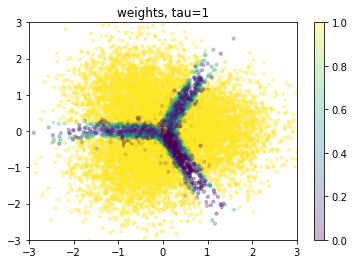

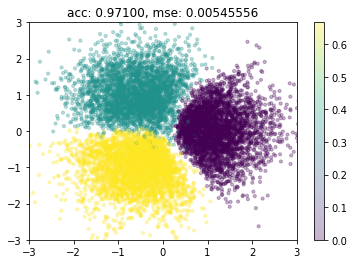

epoch 300, loss -0.1775074452161789, z_ll_loss 0.42935317754745483, weights 1.0, wll -0.1775074452161789


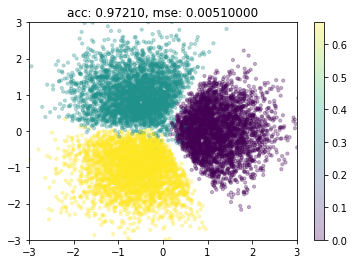

epoch 600, loss -0.19463539123535156, z_ll_loss 0.9128064513206482, weights 1.0, wll -0.19463539123535156


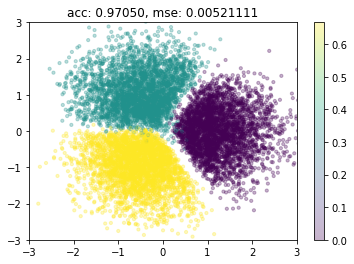

epoch 900, loss -0.19614072144031525, z_ll_loss 0.8554180264472961, weights 1.0, wll -0.19614072144031525


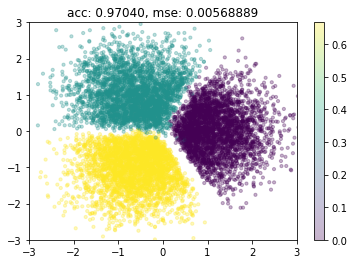

epoch 1200, loss -0.18976779282093048, z_ll_loss 0.8672900199890137, weights 1.0, wll -0.18976779282093048


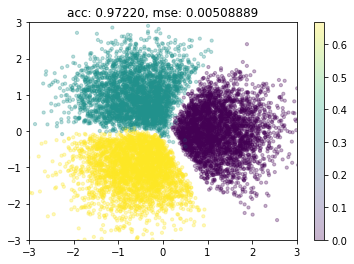

epoch 1500, loss -0.20460745692253113, z_ll_loss 1.0295135974884033, weights 1.0, wll -0.20460745692253113


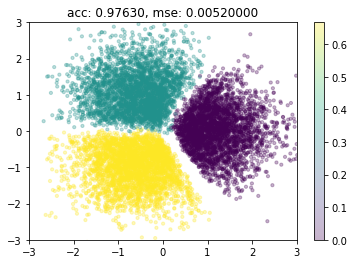

epoch 1800, loss -0.20108245313167572, z_ll_loss 1.1830265522003174, weights 1.0, wll -0.20108245313167572


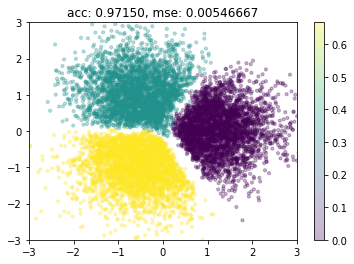

epoch 2100, loss -0.20728932321071625, z_ll_loss 1.1750563383102417, weights 1.0, wll -0.20728932321071625


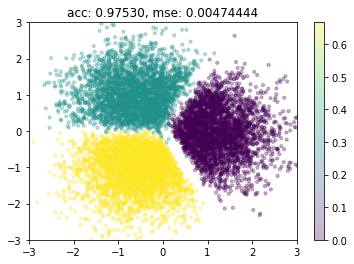

epoch 2400, loss -0.21182870864868164, z_ll_loss 1.1829932928085327, weights 1.0, wll -0.21182870864868164


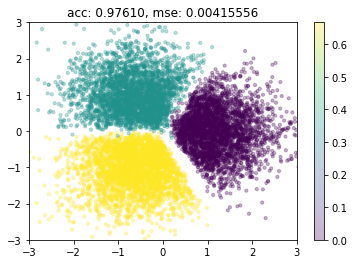

epoch 2700, loss -0.20556166768074036, z_ll_loss 1.0986160039901733, weights 1.0, wll -0.20556166768074036


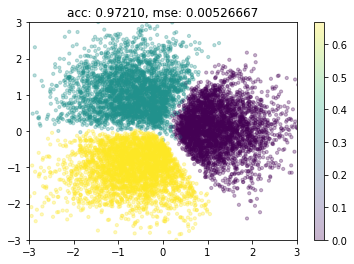

epoch 3000, loss -0.19653621315956116, z_ll_loss 0.99748295545578, weights 1.0, wll -0.19653621315956116


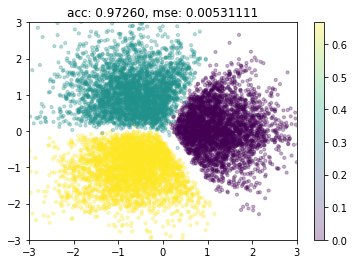

In [4]:
# hyper-parameters
# ----------- train -------------
device = "cuda"
epoch = 3000
lr = 1e-3

# ----------- data --------------
data_num = 10000
x_dim = 2
y_dim = 1

# ----------- model -------------
hidden_size = 256
layer_num = 8

# ----------- plot -------------
plt_point_size = 10
plt_alpha = 0.3
xlim = (-3, 3)
ylim = (-3, 3)

# reproduciability
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# generate data
env = ThreeClustersX(cluster_num=3,
                     div=0.7,
                     x_noise_std=0.2, y_noise_std=0)

train_x = env.generate_random_x(num=data_num).astype(np.float32)
train_y = env.noisy_forward(train_x).astype(np.float32)
vali_x = env.generate_random_x(num=data_num).astype(np.float32)
vali_y = env.noisy_forward(vali_x).astype(np.float32)
test_x = env.generate_random_x(num=data_num).astype(np.float32)
test_y = env.noisy_forward(test_x).astype(np.float32)

plot_scatter(train_x[:, 0],
             train_x[:, 1],
             train_y,
             "Clusters_data_distribution")
vali_loss = train_weights(train_x, train_y)
tau = 1
train_and_plot_conditional_inn(
    tau, train_x, train_y, vali_x, vali_y, test_x, test_y, vali_loss)

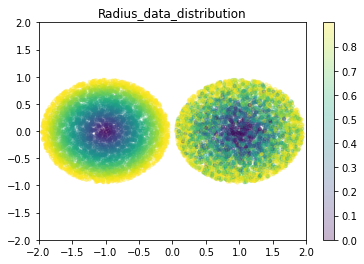

sn 0, ep 499, train_loss 0.030416205525398254, best_vali_loss 0.02316642738878727
sn 0, ep 999, train_loss 0.02154153399169445, best_vali_loss 0.01729571633040905
sn 0, ep 1499, train_loss 0.019525369629263878, best_vali_loss 0.015296217054128647
sn 0, ep 1999, train_loss 0.018529897555708885, best_vali_loss 0.015128728933632374
sn 1, ep 499, train_loss 0.02866114303469658, best_vali_loss 0.027988044545054436
sn 1, ep 999, train_loss 0.021099479869008064, best_vali_loss 0.0200386643409729
sn 1, ep 1499, train_loss 0.019508838653564453, best_vali_loss 0.018968427553772926
sn 1, ep 1999, train_loss 0.019825583323836327, best_vali_loss 0.018953552469611168
sn 2, ep 499, train_loss 0.029566127806901932, best_vali_loss 0.023771801963448524
sn 2, ep 999, train_loss 0.020777417346835136, best_vali_loss 0.017724931240081787
sn 2, ep 1499, train_loss 0.019054794684052467, best_vali_loss 0.0163988396525383
sn 2, ep 1999, train_loss 0.018674517050385475, best_vali_loss 0.016329888254404068
sn 3, 

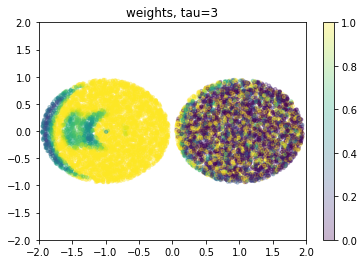

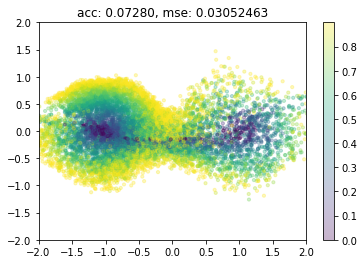

epoch 300, loss -1.3237954378128052, z_ll_loss 0.02006400004029274, weights 1.0, wll -1.3237954378128052


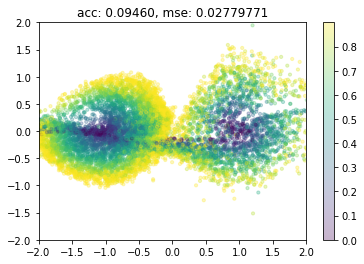

epoch 600, loss -1.0104247331619263, z_ll_loss -0.04150184988975525, weights 1.0, wll -1.0104247331619263


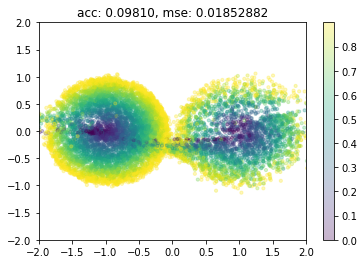

epoch 900, loss -2.0263876914978027, z_ll_loss 7.983813762664795, weights 1.0, wll -2.0263876914978027


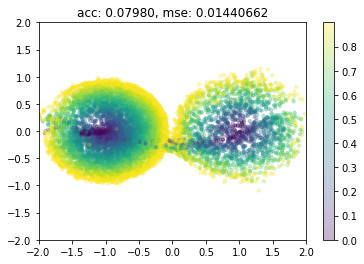

epoch 1200, loss -1.0613658428192139, z_ll_loss 28.366477966308594, weights 1.0, wll -1.0613658428192139


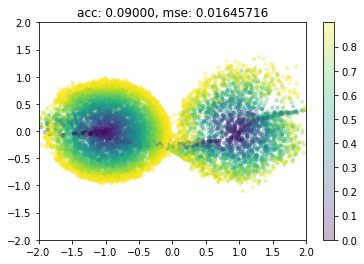

epoch 1500, loss -2.2731666564941406, z_ll_loss 2.2113959789276123, weights 1.0, wll -2.2731666564941406


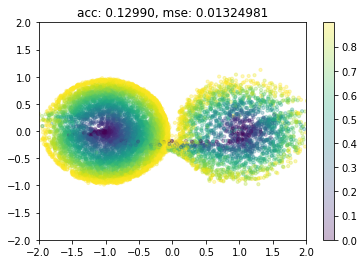

epoch 1800, loss -2.724745273590088, z_ll_loss 5.459961414337158, weights 1.0, wll -2.724745273590088


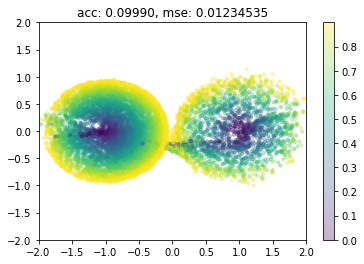

epoch 2100, loss -1.4210162162780762, z_ll_loss 4.315335750579834, weights 1.0, wll -1.4210162162780762


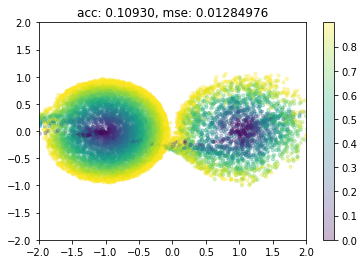

epoch 2400, loss -2.751857042312622, z_ll_loss 3.460122585296631, weights 1.0, wll -2.751857042312622


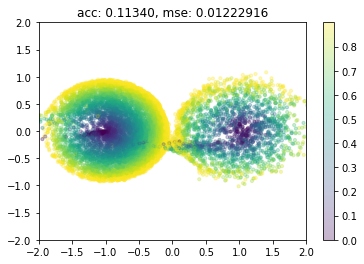

epoch 2700, loss -2.601820945739746, z_ll_loss 4.044277667999268, weights 1.0, wll -2.601820945739746


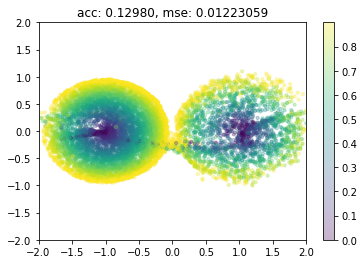

epoch 3000, loss -2.867506742477417, z_ll_loss 3.7478091716766357, weights 1.0, wll -2.867506742477417


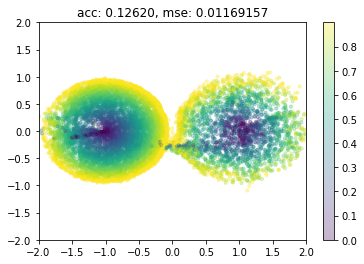

In [5]:
# hyper-parameters
# ----------- train -------------
device = "cuda:0"
epoch = 3000
lr = 1e-3

# ----------- data --------------
data_num = 10000
x_dim = 2
y_dim = 1

# ----------- model -------------
hidden_size = 256
layer_num = 8

# ----------- plot -------------
plt_point_size = 10
plt_alpha = 0.3
xlim = (-2, 2)
ylim = (-2, 2)

# reproduciability
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# generate data
env = TwoClustersRhoY(noise=[0.2, 0], radi=0.9)

train_x = env.generate_random_x(num=data_num).astype(np.float32)
train_y = env.noisy_forward(train_x).astype(np.float32)
vali_x = env.generate_random_x(num=data_num).astype(np.float32)
vali_y = env.noisy_forward(vali_x).astype(np.float32)
test_x = env.generate_random_x(num=data_num).astype(np.float32)
test_y = env.noisy_forward(test_x).astype(np.float32)

plot_scatter(train_x[:, 0],
             train_x[:, 1],
             train_y,
             "Radius_data_distribution")
vali_loss = train_weights(train_x, train_y)
tau = 3
train_and_plot_conditional_inn(
    tau, train_x, train_y, vali_x, vali_y, test_x, test_y, vali_loss)